This notebook goes through the process of how to **reconstruct** **curves/surfaces** using **SDFs**.

# IMPORTS

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from spomso.cores.helper_functions import generate_grid, smarter_reshape, vector_smarter_reshape
from spomso.cores.geom_2d import PointCloud2D, Circle
from spomso.cores.geom import Points

# PARAMETERS

In [2]:
# size of the volume
co_size = 5, 5
# resolution of the volume
co_resolution = 400, 400

# reconstruction types: CONV, SLOWSTART, SMOOTH_RELU
reconstruction_type = "CONV"

# show the fields
show = True

# FUNCTIONS

This **function** is used to **reconstruct** the **points** that should be on a certain **curve/surface**:

In [3]:
def reconstruction_function(field_, distance, threshold=0.02):

    field_ = smarter_reshape(field_, co_resolution)

    mask = (field_ >= distance - threshold) * (field_ <= distance + threshold)

    grad = np.asarray(
        np.gradient(field_,
                    *tuple(co_size[i] / co_res_new[i] for i in range(len(co_size)))
                    )
    )
    vec = grad[:, mask]
    masked_coordinates = vector_smarter_reshape(coor, co_resolution)[:, mask]
    step = field_[mask]

    new_coordinates = np.zeros((3, np.count_nonzero(mask)))
    new_coordinates[:len(co_size), :] = masked_coordinates[:len(co_size), :] - step * vec

    return new_coordinates

# COORDINATE SYSTEM

Point cloud of coordinates is created with the **generate_grid** function, which takes the size of the coordinate system and the number of points in each direction (**co_resolution**).

In [4]:
coor, co_res_new = generate_grid(co_size, co_resolution)

If there is an even number of points along any direction the function will automatically convert it to an odd number, therefore the origin is always included in the point cloud. The point cloud is a **numpy.ndarray** with a shape of **(D, N)**, where **D** is the number of dimensions and **N** is the number of data points.

# CREATE SDFs

To showcase **surface reconstruction** a **circle** of **radius 1** is sampled at **25** points:

Define points on a **circle** in 3D space:

In [5]:
# number of sampled points
n_points = 25
# radius of the circle along which the points are samples
radius = 1

coordinates = [[radius*np.cos(phi_), radius*np.sin(phi_), 0] for phi_ in np.linspace(0, 2*np.pi, n_points+1)]
coordinates = np.asarray(coordinates).T

Create a **point cloud** object:

In [6]:
points = Points(coordinates)

Create a **SDF** from the **point cloud**:

In [7]:
point_cloud = PointCloud2D(points.cloud)

Evaluate the SDF to create a signed distance field 2D map:

In [8]:
original = point_cloud.create(coor)

# PLOT the ORIGINAL SDF

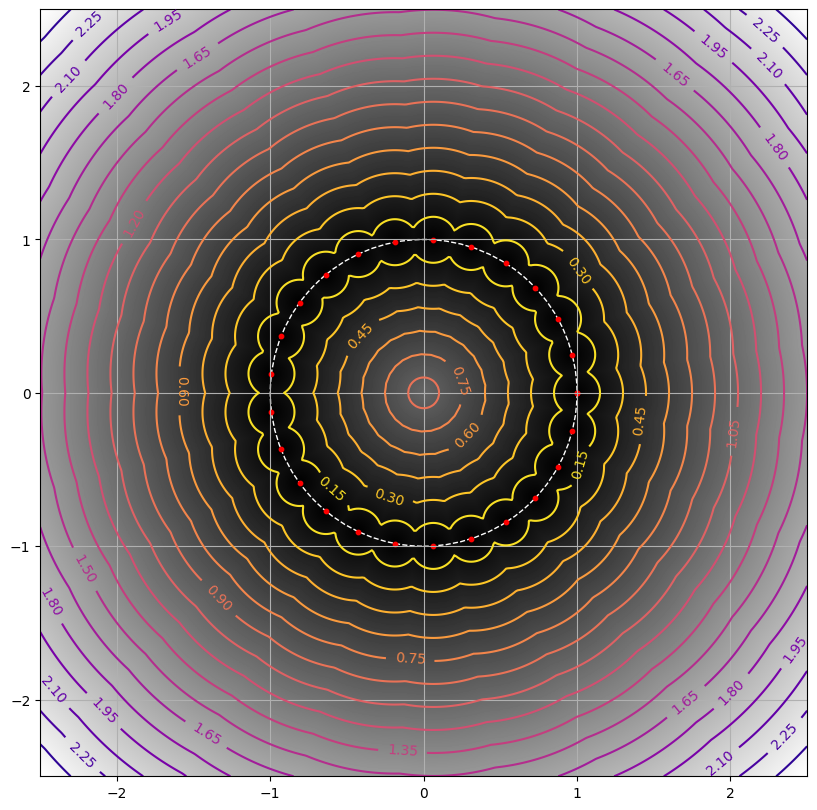

In [9]:
if show:
    fig, ax = plt.subplots(1, 1, figsize=(8.25, 8.25))
    original_field = smarter_reshape(original, co_resolution)
    ax.imshow(original_field[:, :].T,
              cmap="binary_r",
              extent=(-co_size[0] / 2, co_size[0] / 2,
                      -co_size[1] / 2, co_size[1] / 2),
              origin="lower"
              )
    cs = ax.contour(coor[0].reshape(co_res_new[0], co_res_new[1]),
                    coor[1].reshape(co_res_new[0], co_res_new[1]),
                    original_field[:, :],
                    cmap="plasma_r",
                    levels=20)
    ax.clabel(cs, inline=True, fontsize=10)
    ax.grid()

    circle_plt = plt.Circle((0, 0), radius, color='white', linestyle="--", fill=False)
    ax.add_patch(circle_plt)

    ax.scatter(coordinates[0], coordinates[1], s=10, color="red")

    fig.tight_layout()
    plt.show()

# MODIFY the SDF

The **sparse/original SDF** can be used to **reconstruct** the **circle** or another **curve/surface**. **4** approaches are outlined below:

**CONV** -  an averaging convolutional kernel is convolved with the SDF.
This approach produces a smooth and fairly accurate field near the surface, but at the edges the field is noticeably wrong.

**SLOWSTART** - the slowstart function is applied to the SDF which blurs the values close to the surface, but far away the SDF if accurate to the specified threshold.

**SMOOTH_RELU** - the **squareplus** function is applied to the SDF which blurs the values close to the surface, but far away the SDF if accurate to the specified threshold.

**NOTHING** - the SDF of the sparse circle is accurate far away from the surface.

In [10]:
if reconstruction_type == "CONV":
    point_cloud.conv_averaging((5, 5), 50, co_resolution)
elif reconstruction_type == "SLOWSTART":
    point_cloud.slowstart(1.5, threshold=0.005, ground=False)
elif reconstruction_type == "SMOOTH_RELU":
    point_cloud.smooth_relu(1.5, threshold=0.005)
else:
    print("Field of the sparse circle will be used for reconstruction.")

Print the applied **modifications**:

In [11]:
print(point_cloud.modifications)

['conv_averaging']


Evaluate the SDF to create a signed distance field 2D map:

In [12]:
modified = point_cloud.create(coor)

# PLOT the MODIFIED SDF

Drawing results...


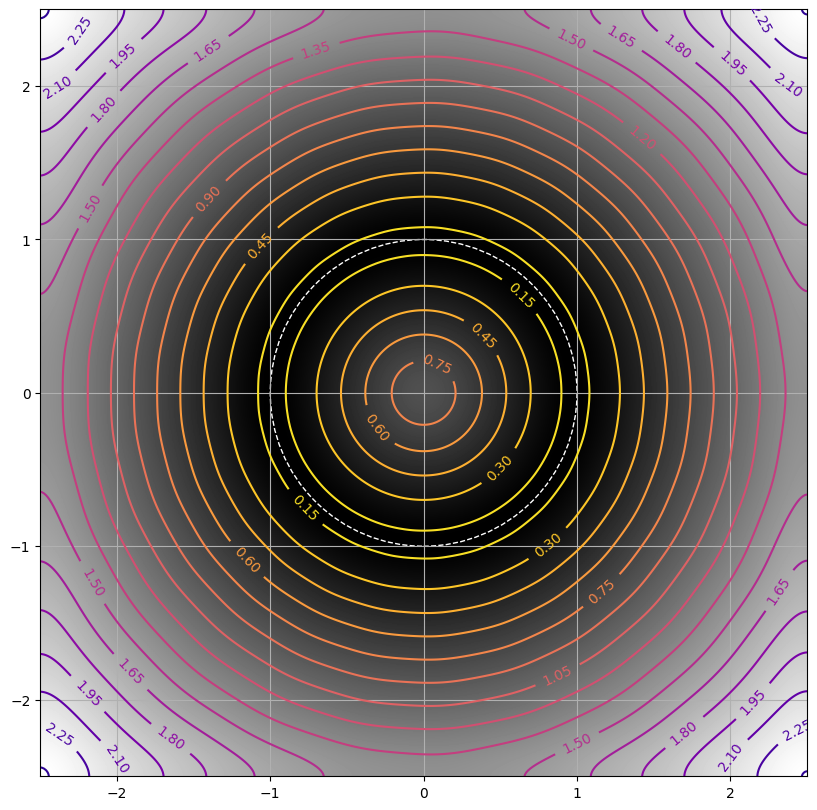

In [13]:
print("Drawing results...")
if show:
    fig, ax = plt.subplots(1, 1, figsize=(8.25, 8.25))
    modified_field = smarter_reshape(modified, co_resolution)
    ax.imshow(modified_field[:, :].T,
              cmap="binary_r",
              extent=(-co_size[0] / 2, co_size[0] / 2,
                      -co_size[1] / 2, co_size[1] / 2),
              origin="lower"
              )
    cs = ax.contour(coor[0].reshape(co_res_new[0], co_res_new[1]),
                    coor[1].reshape(co_res_new[0], co_res_new[1]),
                    modified_field[:, :],
                    cmap="plasma_r",
                    levels=20)
    ax.clabel(cs, inline=True, fontsize=10)
    ax.grid()

    circle_plt = plt.Circle((0, 0), radius, color='white', linestyle="--", fill=False)
    ax.add_patch(circle_plt)

    fig.tight_layout()
    plt.show()

# RECONSTRUCT

The **reconstruction function** calculates the **gradient** of the **modified SDF** at a certain **distance**, calculates the **coordinates** of those points, and back-propagates their positions to where the **surface** should have been:

**Reconstruct** the **point cloud**:

In [14]:
if reconstruction_type == "CONV":
    new_coordinates = reconstruction_function(modified, 1.0, threshold=0.02)
elif reconstruction_type == "SLOWSTART":
    new_coordinates = reconstruction_function(modified, 1.5, threshold=0.05)
elif reconstruction_type == "SMOOTH_RELU":
    new_coordinates = reconstruction_function(modified, 1.5, threshold=0.05)
else:
    new_coordinates = reconstruction_function(modified, 1.5, threshold=0.05)

Create an **SDF** from the **point cloud**:

In [15]:
new_point_cloud = PointCloud2D(Points(new_coordinates).cloud)

Evaluate the SDF to create a signed distance field 2D map:

In [16]:
final = new_point_cloud.create(coor)

# PLOT MODIFIED

Drawing results...


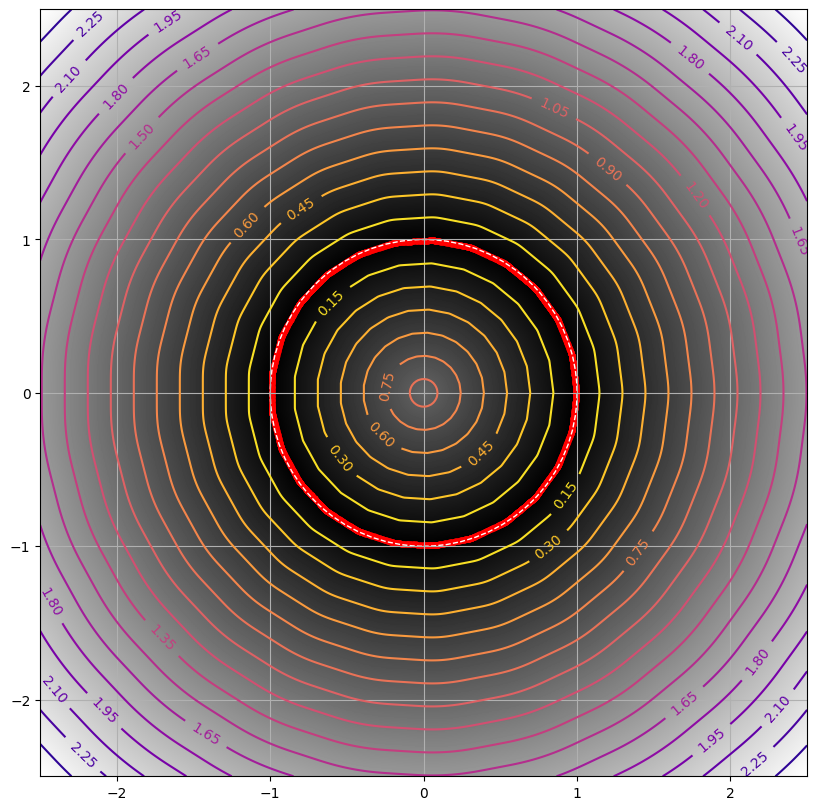

In [17]:
print("Drawing results...")
if show:
    fig, ax = plt.subplots(1, 1, figsize=(8.25, 8.25))
    final_field = smarter_reshape(final, co_resolution)
    ax.imshow(final_field[:, :].T,
              cmap="binary_r",
              extent=(-co_size[0] / 2, co_size[0] / 2,
                      -co_size[1] / 2, co_size[1] / 2),
              origin="lower"
              )
    cs = ax.contour(coor[0].reshape(co_res_new[0], co_res_new[1]),
                    coor[1].reshape(co_res_new[0], co_res_new[1]),
                    final_field[:, :],
                    cmap="plasma_r",
                    levels=20)
    ax.clabel(cs, inline=True, fontsize=10)
    ax.grid()

    ax.scatter(new_coordinates[0], new_coordinates[1], s=10, color="red")

    circle_plt = plt.Circle((0, 0), radius, color='white', linestyle="--", fill=False)
    ax.add_patch(circle_plt)

    fig.tight_layout()
    plt.show()


# ITERATIVE RECONSTRUCT

With the **slowstart** and **smooth_relu** approaches it is sometimes better to run the same algorithm many times:

In [18]:
reconstruction_iterations = 5

if reconstruction_type in ("SLOWSTART", "SMOOTH_RELU"):
    new_coordinates_i = new_coordinates.copy()   
    for i in range(reconstruction_iterations):
        pc_i = PointCloud2D(Points(new_coordinates).cloud)
        if reconstruction_type == "SLOWSTART":
            pc_i.slowstart(1.5, threshold=0.005, ground=False)
            pcf_i = pc_i.create(coor)
            nc_i = reconstruction_function(pcf_i, 1.5, threshold=0.05)
        elif reconstruction_type == "SMOOTH_RELU":
            pc_i.smooth_relu(1.5, threshold=0.005)
            pcf_i = pc_i.create(coor)
            nc_i = reconstruction_function(pcf_i, 1.5, threshold=0.05)
    pc_final = PointCloud2D(Points(nc_i).cloud)
    final_i = pc_final.create(coor)
    final_field = smarter_reshape(final_i, co_resolution)

# COMBINED PLOT

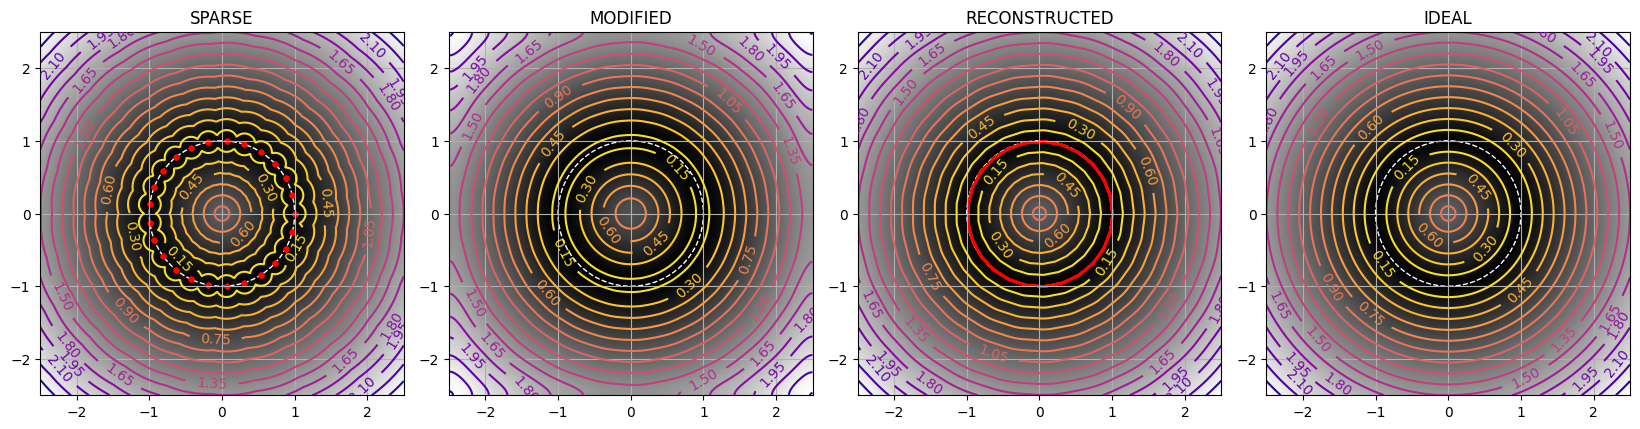

In [19]:
if show:

    circle = Circle(radius)
    circle.onion(0)
    ideal = circle.create(coor)
    ideal_field = smarter_reshape(ideal, co_resolution)

    fields = [original_field, modified_field, final_field, ideal_field]
    titles = ["SPARSE", "MODIFIED", "RECONSTRUCTED", "IDEAL"]

    fig, axs = plt.subplots(1, 4, figsize=(8.25*2, 8.25*2/4), sharey="col")
    for i in range(4):
        axs[i].imshow(fields[i][:, :].T,
                  cmap="binary_r",
                  extent=(-co_size[0] / 2, co_size[0] / 2,
                          -co_size[1] / 2, co_size[1] / 2),
                  origin="lower"
                  )
        cs = axs[i].contour(coor[0].reshape(co_res_new[0], co_res_new[1]),
                            coor[1].reshape(co_res_new[0], co_res_new[1]),
                            fields[i][:, :],
                            cmap="plasma_r",
                            levels=20)
        axs[i].clabel(cs, inline=True, fontsize=10)
        axs[i].grid()

        axs[i].set_title(titles[i])

        axs[0].scatter(coordinates[0], coordinates[1], s=10, color="red")
        axs[2].scatter(new_coordinates[0], new_coordinates[1], s=0.1, color="red")

        circle_plt = plt.Circle((0, 0), radius, color='white', linestyle="--", fill=False)
        axs[i].add_patch(circle_plt)

    fig.tight_layout()
    plt.show()